## K-nearest neighbors, Softmax classifier, Image classification Project (15 pts)
<em>University of Virginia - Introduction to Computer Vision - Spring 2018 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this project assignment we will apply our knowledge of machine learning to design an image classifier. For this purpose we will use a new library for tensor (matrix) manipulation [Pytorch](http://pytorch.org/). It is like numpy, you can slice, index, and do matrix operations. But pytorch has a lot of other additional features that we will exploit in this and the following final project. First we will try pytorch with a few examples and once that is done we will move on to image classification.



### 1. Pytorch Introduction (0 pts)
At its core Pytorch is a tensor manipulation library similar to numpy. We will see here a few examples of how to use it. First, let's install pytorch using pip3. If you are working offline on a supported platform you can run this in the command line.

In [ ]:
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip install http://www.cs.virginia.edu/~vicente/vision/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip install torchvision
!pip install --no-cache-dir -I pillow
# Important! You might need to go to Runtime->Restart Runtime after 
# executing this cell so that things are setup properly.
# Also PLEASE delete the output of this cell, do not include it in the 
# assignment. Thanks!

**1.1 Basic Tensor Operations:** Let's create some image tensors and perform some operations.

In [1]:
import torch

# Let's create two matrices of size 4x4 and full of ones.
a = torch.ones(4, 4)
b = torch.ones(4, 4)

# Just like in numpy you can get the shape of a tensor.
print(a.shape)
print(b.shape)

# Just like in numpy operations are overloaded to avoid for-loops.
print(3 * a + 2 * (b  ** 2))

# Compute a dot product between the two matrices.
print(torch.sum(a * b))

torch.Size([4, 4])
torch.Size([4, 4])

 5  5  5  5
 5  5  5  5
 5  5  5  5
 5  5  5  5
[torch.FloatTensor of size 4x4]

16.0


**1.2 Image Transformations:** Let's see an example of how to read an image into a pytorch tensor, resize it so that its longest side is 256 and then extract the 224x224 center crop. Then convert back to numpy and display. Note: I took the picture of this cat at the Edgar Allan Poe's Museum in Richmond.

torch.Size([4, 224, 224])


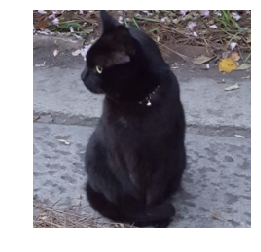

In [2]:
import io, requests
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.png'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# These are basic image transformations included in pytorch's torchvision.
preprocess = transforms.Compose([
   # Resizes image to 256 on its smallest side.
   transforms.Resize(256),
   # Crops the center 224x224 square.
   transforms.CenterCrop(224),
   # Converts image to a torch tensor.
   transforms.ToTensor()
])

# Try commenting center-crop or resize above and see things aer working.
img = preprocess(img_pil)

# Shape will be 3x224x224 because in pytorch the channel dimension in images
# is the first dimension, then height, then width.
print(img.shape)

# In order to display properly we have to convert back to a numpy array
# because matplotlib does not support pytorch tensors.
# And also we need to reshuffle the dimensions so that the channel dimension
# is the last dimension.
# Notice also that we can transform a pytorch tensor into a numpy tensor using
# the method .numpy()
plt.figure()
plt.imshow(np.transpose(img.numpy(), (1,2,0))); plt.grid('off')
plt.axis('off'); plt.show()

**1.3 Image Processing:** Let's see now how to perform some basic image processing and slicing operations on this matrix.

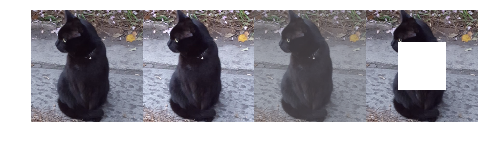

In [6]:
# Increase or decrease brightness.
# torch.clamp to avoid underflows or overflows.
# multiplication * will perform scalar * matrix multiplication
# so we avoid for-loops.
bright_img = torch.clamp(1.2 * img, 0.0, 1.0) 
dark_img = torch.clamp(0.8 * img, 0.0, 1.0)

# Crop out the center of the image.
cimg = img.clone()  # Create a full copy of the image.
# Slicing, and indexing work the same as in numpy! 
# e.g. Put zeros in the matrix center 64 pixels from all sides.
cimg[:, 64:-64, 64:-64] = 0

# Plot all results side-by-side.
plt.figure()
# torch.cat to concatenate tensors along a dimension.
out = torch.cat((img, bright_img, dark_img, cimg), 2) 
plt.imshow(np.transpose(out.numpy(), (1,2,0))); plt.grid('off')
plt.axis('off'); plt.show()


**Final Comments:** For a full documentation of all the ways you can manipulate tensors use the pytorch documentation http://pytorch.org/docs/0.3.1/. Discuss in Piazza if unsure. Feel free to experiment in the above section with many tensor manipulations, e.g. you should be able to translate all that you learned to do in numpy to pytorch<br/><br/>

### 2. k-Nearest neighbors classifier (10pts)

**2.1 Data Loading:** In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects. First, let's download a local copy from the CS server.

In [ ]:
!wget -nc https://www.cs.virginia.edu/~vicente/vision/cifar-10-python.tar.gz -P datalab
!tar xf datalab/cifar-10-python.tar.gz -C datalab
# Please delete the output generated by this cell.

**2.2 Data Sampling:** Now let's load the dataset using the pre-existing dataloader written in pytorch.

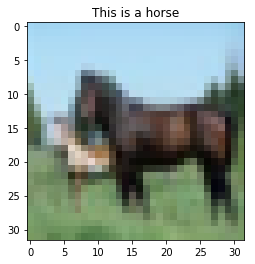

In [4]:
import torchvision
from torchvision import datasets

# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
train_data = datasets.CIFAR10('./datalab', train = True)

# This samples the 12-th image from the dataset.
# Try changing the index below to see different images in the dataset.
image, category = train_data[12]

# Display the image and its label.
plt.figure()
plt.title('This is a %s' % categories[category])
plt.imshow(image); plt.grid('off')
plt.show()

** 2.3 Compute k-Nearest neighbors (4pts):** Retrieve the top K = 10 nearest neighbors from all the 50k CIFAR10 images for our black-cat.jpg image and show them below. Use cosine similarity as your retrieval measure (see https://en.wikipedia.org/wiki/Cosine_similarity), i.e. you need to resize the black-cat.jpg image so you can compare it with the CIFAR10 images. This measure is similar to the normalized cross correlation measure from the previous assignment. Show below (a) the black-cat.jpg image, (b) the categories for the top 10 images returned, and (c) the top 10 images returned. Sample results are provided below.

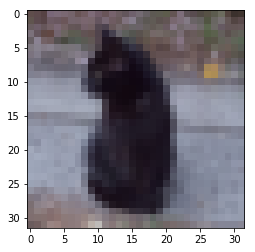

['cat', 'cat', 'cat', 'cat', 'dog', 'bird', 'bird', 'cat', 'cat', 'bird']


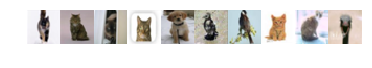

In [5]:
import math

K = 10

img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# Your code goes here.
preprocess = transforms.Compose([
   transforms.Resize(32),
   transforms.ToTensor()
])

black_cat = preprocess(img_pil)
plt.figure()
plt.imshow(np.transpose(black_cat, (1,2,0)),)
plt.grid('off')
plt.show()

sim_scores = []
category_idxs = []
for img, category in train_data:
    img = preprocess(img)
    cos_sim =  torch.sum(black_cat * img) / (np.sqrt(torch.sum(black_cat ** 2)) * np.sqrt(torch.sum(img ** 2)))
    sim_scores.append(cos_sim)
    category_idxs.append(category)

args = np.argsort(sim_scores)[::-1]
print([categories[category_idxs[arg]] for arg in args[:K]])

plt.figure()
out = np.concatenate([train_data[arg][0] for arg in args[:K]], axis=1)
plt.imshow(out); 
plt.grid('off')
plt.axis('off'); plt.show()

**2.4 Evaluate the k-nearest neighbors classifier (6pts):** Now we will load the test images of CIFAR-10 and compute the accuracy of the previously implemented k-nearest neighbors classifier on the test images. Accuracy is defined as the number of images for which the k-nearest classifier predicted the correct category divided by the total number of images in the test set. Note: Take into account that there are 10 thousand images in the test set, so you need a fast implementation. Hint: You can put all 50k images in a single tensor of size (50000, 3072), all 10k images in a single tensor of size (10000, 3072), convert those tensors to numpy arrays and then use scipy.spatial.distance.cdist to compute all pairwise distances at once, take into account that this will compute distance and not similarity.

In [16]:
from scipy.spatial import distance

def most_common(lst):
    return max(((item, lst.count(item)) for item in set(lst)), key=lambda a: a[1])[0]

validation_data = datasets.CIFAR10('./datalab', train = False)

count_correct = 0
train_tensor = np.asarray([np.asarray(train_data[i][0]) for i in range(50000)]).reshape(-1,3072)
val_tensor = np.asarray([np.asarray(validation_data[i][0]) for i in range(10000)]).reshape(-1, 3072)
dist = distance.cdist(train_tensor, val_tensor, 'cosine')
sort_arg = np.argsort(dist, axis=0)

for i in range(10000):
    real_category = validation_data[i][1]
    pred_categories = [train_data[j][1] for j in sort_arg[:10,i]]
    pred_category = most_common(pred_categories)
    if pred_category == real_category:
        count_correct += 1

print('Accuracy : %.2f%%' % \
      (100 * (count_correct / 10000)))

Accuracy : 36.02%


**Final Comments:** You could try more experiments changing the distance function, or the value of K and see if that improves the accuracy. Take into account that 36% accuracy while not great is more than three times than random guessing, since there are 10 classes, random guessing would only get you a 10% accuracy.

### 3. Softmax Classifier (5pts)
Here we will walk through learning a softmax classifier using pytorch's automatic differentiation capabilities. We will apply here several capabilities of pytorch that will be used for more complex models such as deep neural networks so pay close attention to every step.

**3.1 Model definition:** First let's see how to define a learnable model in Pytorch using the nn package. This model is untrained so the parameters such as the weight-matrix and bias-vector of the linear layer will have random parameters at this stage. i.e. if you run this cell multiple times, each time the weight and bias tensors will be populated with different values.

In [17]:
from torch import nn
from torch.autograd import Variable

# This is the softmax classifier as studied in class.
class Classifier(nn.Module):
  
    def __init__(self):
        super(Classifier, self).__init__()
        # Linear transformation layer.
        self.linear = nn.Linear(3 * 32 * 32, 10)
        # Softmax operator.
        self.log_softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        gx = self.linear(x)
        yhat = self.log_softmax(gx)
        return yhat
      
# Let's inspect the parameters of this classifier.
classifier = Classifier()
print('weight-matrix: ', classifier.linear.weight.shape)
print('bias-vector: ', classifier.linear.bias.shape)

# Now let's try using it on a batch 5 of images.
dummy_input = Variable(torch.rand(5, 3 * 32 * 32))
out = classifier(dummy_input)
print(out.exp())

weight-matrix:  torch.Size([10, 3072])
bias-vector:  torch.Size([10])
Variable containing:
 0.0924  0.1038  0.0735  0.1350  0.1193  0.1076  0.0538  0.1720  0.0510  0.0916
 0.0889  0.0907  0.0555  0.1756  0.1397  0.0910  0.0536  0.1596  0.0592  0.0861
 0.0835  0.0829  0.0557  0.1307  0.1515  0.1190  0.0534  0.1526  0.0511  0.1194
 0.0938  0.0833  0.0805  0.1532  0.1286  0.0894  0.0371  0.1757  0.0444  0.1139
 0.1022  0.0976  0.0713  0.1931  0.0892  0.0793  0.0515  0.1341  0.0482  0.1335
[torch.FloatTensor of size 5x10]



**3.2 Data preparation steps:** Before training a machine learning model, an important step is to prepare your data, including preprocessing steps such as centering the input variables around zero.

In [18]:
from torchvision import datasets
from torch.utils.data import DataLoader

# Convert image to pytorch tensor and normalize input range.
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # This centers the data around zero, and scales the values
    # so that they have unit variance. 
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

# It is possible to pass the transformation function to the data wrappers,
# so that train_data[0] returns a pytorch tensor and a label.
train_data = datasets.CIFAR10(root='./datalab', train = True, transform = preprocess)
validation_data = datasets.CIFAR10(root='./datalab', train = False, transform = preprocess)

x, y = train_data[0]
print('image: ', x.shape)
print('label: ', type(y))

image:  torch.Size([3, 32, 32])
label:  <class 'int'>


Additionally we have dataloader classes to return batches of samples as opposed to single samples from the training data which is useful to train mini-batch algorithms for training. We show below how to use one and sample from it.

In [19]:
batch_size = 128 

# It additionally has utilities for threaded and multi-parallel data loading.
trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)

# Look-up python iterators if you need: 
# https://anandology.com/python-practice-book/iterators.html
x, y = iter(trainLoader).next()
print('batch-of-images: ', x.shape)
print('batch-of-labels: ', y.shape)

batch-of-images:  torch.Size([128, 3, 32, 32])
batch-of-labels:  torch.Size([128])


**3.3 Training Loop (1pt):** Here we will have our mini-batch Stochastic Gradient Descent (SGD) training loop. Make sure you understand every line of code below. Keep in mind that inputs to a nn.Model class have to be wrapped around a Variable because we might need to store the gradients (derivatives) of the inputs and Variable has an attribute .grad to store that. No code needs to be written for this section, you only need to run it.

In [81]:
# Re-initialize the classifier.
classifier = Classifier()

# Let's define the loss function or criterion.
criterion = nn.NLLLoss()

# Number of epochs is the number of times we go over the full training set.
num_epochs = 10

# Learning rate.
learningRate = 0.005

# This is often needed to prepare model for training.
classifier.train()

# Short-cut for the model parameters.
weight = classifier.linear.weight;
bias = classifier.linear.bias;

train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Training loop starts.
for epoch in range(0, num_epochs):
    correct = 0
    cumloss = 0
  # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
        # Flatten the images in the batch to input to the classifier.
        x = Variable(x.view(x.shape[0], 3 * 32 * 32))
        y = Variable(y)
    
        # Compute predictions under the current model.
        yhat = classifier(x)
    
        # Compute the loss with respect to this batch.
        loss = criterion(yhat, y)
        _, max_labels = yhat.data.max(1)
        correct += (max_labels == y.data).sum()
    
    # Set to zero gradients computed in previous iteration.
    if weight.grad is not None:
        weight.grad.data.zero_()
        bias.grad.data.zero_()
    
    # Compute the gradients for the entire model variables,
    # this includes inputs, outputs, and parameters (weight, and bias).
    loss.backward()
    
    # Now we can update the weight and bias parameters.
    weight.data.add_(-learningRate * weight.grad.data)
    bias.data.add_(-learningRate * bias.grad.data)
  
    # if i % 50 == 0: print(epoch, i, loss.data[0])
    cumloss += loss.data[0]
    
    train_losses.append(cumloss / 50000)
    train_acc.append(correct / 50000)
    print(epoch, 'training-loss: ', cumloss / 50000)
    print(epoch, 'training-accuracy: ', correct / 50000)
  
    correct = 0
    cumloss = 0
    # Compute accuracy on the test set.
    for (i, (x, y)) in enumerate(valLoader):
    # Flatten the images in the batch to input to the classifier.
        x = Variable(x.view(x.shape[0], 3 * 32 * 32), requires_grad = False)
        y = Variable(y, requires_grad = False)
    
        # Compute predictions under the current model.
        yhat = classifier(x)
        _, max_labels = yhat.data.max(1)
        correct += (max_labels == y.data).sum()
        cumloss += loss.data[0]
    
    val_losses.append(cumloss / 10000)
    val_acc.append(correct / 10000)
    print(epoch, 'validation-loss: ', cumloss / 10000)
    print(epoch, 'validation-accuracy: ', correct / 10000)
    print('\n')

0 training-loss:  4.8882975578308104e-05
0 training-accuracy:  0.12212
0 validation-loss:  0.0193087753534317
0 validation-accuracy:  0.1601


1 training-loss:  4.6283292770385745e-05
1 training-accuracy:  0.16318
1 validation-loss:  0.01828190064430237
1 validation-accuracy:  0.1722


2 training-loss:  4.56251859664917e-05
2 training-accuracy:  0.17982
2 validation-loss:  0.01802194845676422
2 validation-accuracy:  0.198


3 training-loss:  4.451122760772705e-05
3 training-accuracy:  0.19904
3 validation-loss:  0.017581934905052186
3 validation-accuracy:  0.1991


4 training-loss:  4.465863227844238e-05
4 training-accuracy:  0.20116
4 validation-loss:  0.01764015974998474
4 validation-accuracy:  0.2124


5 training-loss:  4.3973116874694825e-05
5 training-accuracy:  0.21284
5 validation-loss:  0.017369381165504457
5 validation-accuracy:  0.2086


6 training-loss:  4.543099880218506e-05
6 training-accuracy:  0.20936
6 validation-loss:  0.017945244526863097
6 validation-accuracy:  0.222

What is the final accuracy of this model after training for 10 epochs? Please write it here **(1pt)**: <br>
**training_accuracy: 22.92%** <br>
**validation_accuracy: 23.78%**

**3.4 Predictions using the trained model (2pts):** Show 2 examples of images from the validation set where the model predicts the correct category, and 2 examples where the model predicts the wrong category. Show the predictions with probabilities for each class output from the trained softmax classifier. An example of a correct prediction with the model I trained is shown below.

Positive Examples:


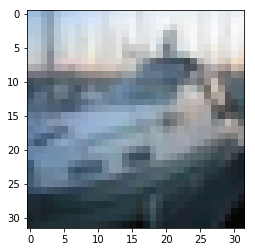

y[airplane] = 0.19
y[automobile] = 0.05
y[bird] = 0.02
y[cat] = 0.04
y[deer] = 0.02
y[dog] = 0.01
y[frog] = 0.01
y[horse] = 0.01
y[ship] = 0.43
y[truck] = 0.22


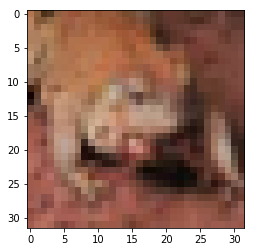

y[airplane] = 0.01
y[automobile] = 0.08
y[bird] = 0.08
y[cat] = 0.1
y[deer] = 0.11
y[dog] = 0.17
y[frog] = 0.22
y[horse] = 0.12
y[ship] = 0.02
y[truck] = 0.09
Negative Examples:


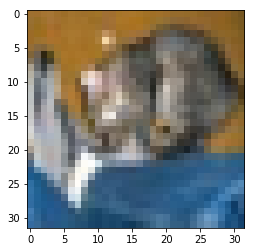

y[airplane] = 0.07
y[automobile] = 0.16
y[bird] = 0.09
y[cat] = 0.09
y[deer] = 0.05
y[dog] = 0.14
y[frog] = 0.11
y[horse] = 0.06
y[ship] = 0.16
y[truck] = 0.07


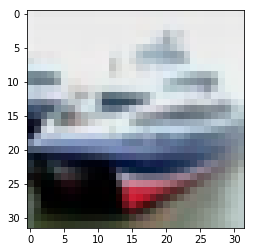

y[airplane] = 0.21
y[automobile] = 0.09
y[bird] = 0.03
y[cat] = 0.03
y[deer] = 0.01
y[dog] = 0.01
y[frog] = 0.02
y[horse] = 0.01
y[ship] = 0.26
y[truck] = 0.35


In [80]:
# Your code goes here.
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

x, y = iter(valLoader).next()
x_var = Variable(x.view(x.shape[0], 3 * 32 * 32), requires_grad = False)
y_var = Variable(y, requires_grad = False)
    
yhat = classifier(x_var)
_, max_labels = yhat.data.max(1)

plt.figure()

print('Positive Examples:')
count = 0
for idx, max_label in enumerate(max_labels):
    if max_label == y_var.data[idx]:
        plt.imshow(np.transpose(unorm(x[idx]), (1,2,0)))
        plt.show()
        for i in range(10):
            print('y['+ categories[i] + '] = ' + str(round(torch.exp(yhat[idx].data)[i], 2)))
        count += 1
        if count == 2: break

print('Negative Examples:')
count = 0
for idx, max_label in enumerate(max_labels):
    if max_label != y_var.data[idx]:
        plt.imshow(np.transpose(unorm(x[idx]), (1,2,0)))
        plt.show()
        for i in range(10):
            print('y['+ categories[i] + '] = ' + str(round(torch.exp(yhat[idx].data)[i], 2)))
        count += 1
        if count == 2: break

**3.5 Training Analysis (3pts):** Use matplotlib to plot two linecharts, one should have the training accuracy and the validation accuracy in the same figure, the second figure should have the training loss and validation loss in the same figure. The x-axis should indicate the epochs, the y-axis should indicate a range of values for either the accuracy (first figure) or the loss (second figure).

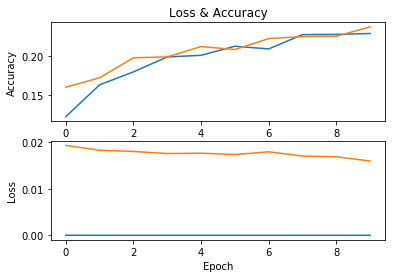

In [98]:
# Your code goes here.
x = np.arange(10)
y1 = train_losses
y2 = val_losses

plt.subplot(2,1,1)
plt.plot(x, train_acc)
plt.plot(x, val_acc)
plt.title('Loss & Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2,1,2)
plt.plot(x, train_losses)
plt.plot(x, val_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

**Final Comments:** A lot of the same concepts used to train this simple linear classifier will be used to train neural network models with many layers. It is important to go over the code in this section carefully. Try changing learning rate, or number of epochs and see how this changes the training results.